In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('/content/synthetic_network_security_dataset_complex.csv')
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
print("\nAttack Type Counts:")
print(df['attack_type'].value_counts())

Dataset Head:
             timestamp        source_ip destination_ip  source_port  \
0  2023-01-01 00:00:00    192.168.93.94   203.0.113.48        19012   
1  2023-01-01 00:01:00    192.168.71.10  203.0.113.104        59620   
2  2023-01-01 00:02:00   192.168.88.236   203.0.113.41        19544   
3  2023-01-01 00:03:00  192.168.152.144  203.0.113.224        12270   
4  2023-01-01 00:04:00  192.168.134.178  203.0.113.199        32297   

   destination_port  protocol  packet_size  duration  bytes_sent  \
0                25         1       861.94      2.38     2388.51   
1                25         1       504.57      1.01     1027.94   
2               443         1       870.27      2.27     2342.81   
3              3389         1       932.77      2.26     2318.52   
4                53         0       522.53      1.02      969.80   

   bytes_received  tcp_flags  geo_location  attack_type  
0         2911.73        242             7            1  
1         1283.72         31      

<ipython-input-4-6c1adf36937f>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.resample('H')['attack_type'].sum().plot(marker='o', title='Attack Frequency Over Time (Hourly)', grid=True)


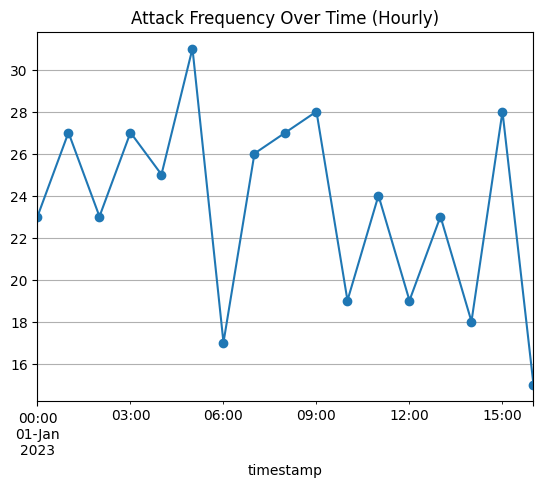

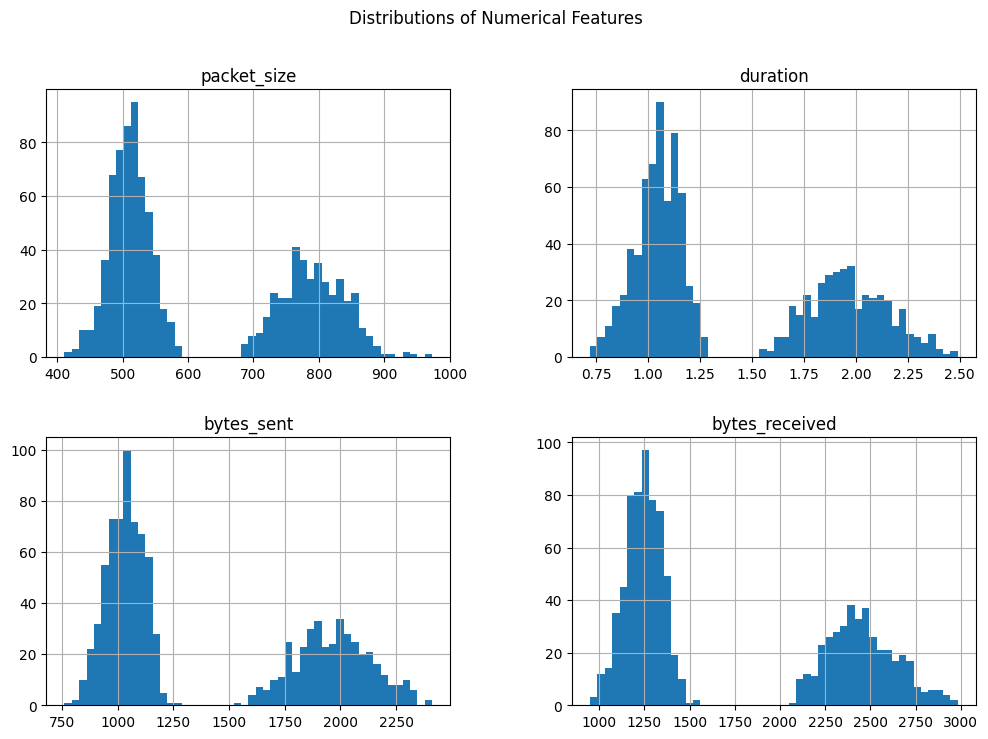

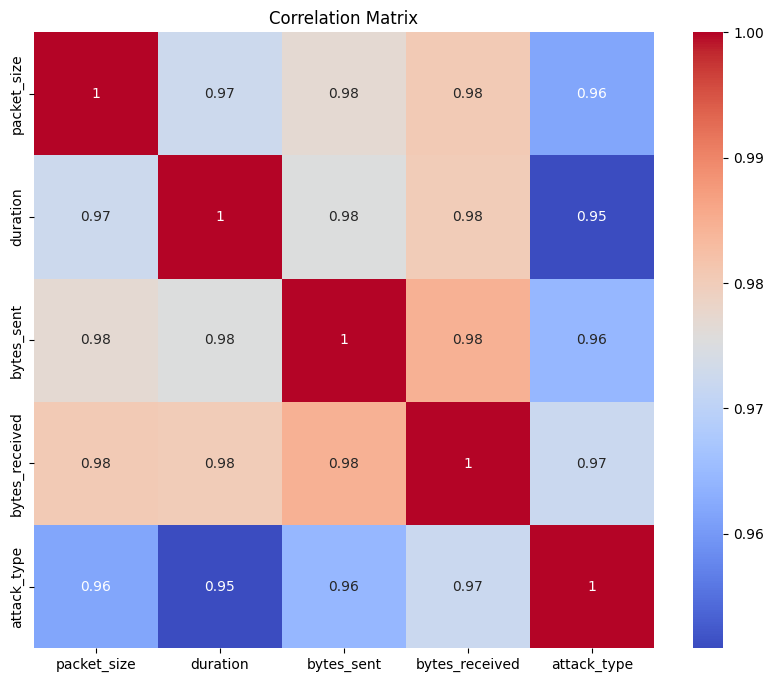

In [4]:
df.resample('H')['attack_type'].sum().plot(marker='o', title='Attack Frequency Over Time (Hourly)', grid=True)
plt.show()
numerical_features = ['packet_size', 'duration', 'bytes_sent', 'bytes_received']
df[numerical_features].hist(bins=50, figsize=(12, 8))
plt.suptitle("Distributions of Numerical Features")
plt.show()
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['attack_type']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numerical_features])
def create_sequences(data_array, window_size=10):
    sequences = []
    for i in range(len(data_array) - window_size):
        sequences.append(data_array[i:i+window_size])
    return np.array(sequences)

window_size = 10
sequences = create_sequences(scaled_data, window_size)
print("Shape of sequences:", sequences.shape)

Shape of sequences: (990, 10, 4)


In [6]:
input_dim = len(numerical_features)
inputs = Input(shape=(window_size, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
encoded = Dropout(0.2)(encoded)

decoded = RepeatVector(window_size)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    sequences, sequences,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 4)               │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,172 (215.52 KB)

 Trainable params: 55,172 (215.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.1995 - val_loss: 0.0967
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0951 - val_loss: 0.0882
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0852 - val_loss: 0.0824
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0771 - val_loss: 0.0789
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0744 - val_loss: 0.0773
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0705 - val_loss: 0.0767
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0724 - val_loss: 0.0760
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0702 - val_loss: 0.0756
Epoch 9/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0700 - val_loss: 0.0745
Epoch 10/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0690 - val_loss: 0.0740
Epoch 11/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0681 - val_loss: 0.0719
Epoch 12/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

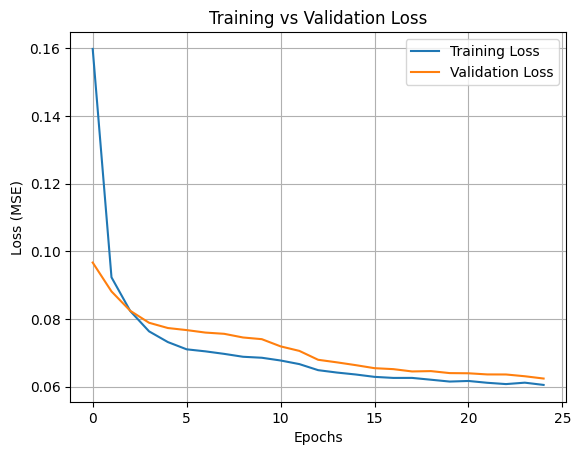

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
reconstructions = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructions, 2), axis=(1, 2))
threshold = np.percentile(mse, 65)
print("Anomaly Detection Threshold (65th percentile):", threshold)
anomaly_df = df.iloc[window_size:].copy()
anomaly_df['reconstruction_error'] = mse
anomaly_df['severity'] = 'normal'
anomaly_df.loc[anomaly_df['reconstruction_error'] > threshold, 'severity'] = 'high'
medium_threshold = np.percentile(mse, 60)
anomaly_df.loc[(anomaly_df['reconstruction_error'] > medium_threshold) &
               (anomaly_df['reconstruction_error'] <= threshold), 'severity'] = 'medium'

print(anomaly_df[['reconstruction_error', 'severity']].head())
num_anomalies = anomaly_df[anomaly_df['severity'] == 'high'].shape[0]
print(f"Total anomalies detected: {num_anomalies}")

severity_counts = anomaly_df['severity'].value_counts()
print("\nAnomaly Severity Breakdown:")
print(severity_counts)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Anomaly Detection Threshold (65th percentile): 0.06528995824992026
                     reconstruction_error severity
timestamp                                         
2023-01-01 00:10:00              0.125046     high
2023-01-01 00:11:00              0.123199     high
2023-01-01 00:12:00              0.117534     high
2023-01-01 00:13:00              0.124841     high
2023-01-01 00:14:00              0.129870     high
Total anomalies detected: 347

Anomaly Severity Breakdown:
severity
normal    594
high      347
medium     49
Name: count, dtype: int64


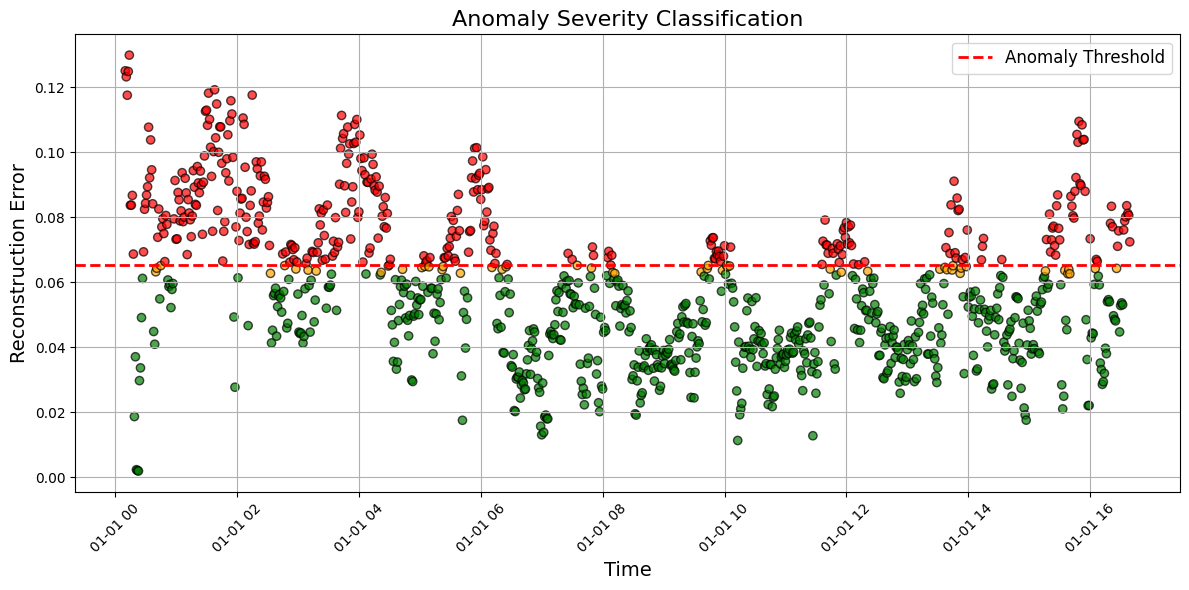

In [13]:
severity_colors = {'normal': 'green', 'medium': 'orange', 'high': 'red'}
plt.figure(figsize=(12,6))
plt.scatter(anomaly_df.index, anomaly_df['reconstruction_error'],
            c=anomaly_df['severity'].map(severity_colors), alpha=0.7, edgecolor='k')
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
plt.title("Anomaly Severity Classification", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Reconstruction Error", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
num_anomalies = anomaly_df[anomaly_df['severity'] == 'high'].shape[0]
print(f"Total anomalies detected: {num_anomalies}")
severity_counts = anomaly_df['severity'].value_counts()
print("\nAnomaly Severity Breakdown:")
print(severity_counts)


Total anomalies detected: 347

Anomaly Severity Breakdown:
severity
normal    594
high      347
medium     49
Name: count, dtype: int64
